In [1]:
import importlib
from typing import Sequence
from datasets.dataset_dict import DatasetDict
import fire
import datasets
import sys
from collections import defaultdict

sys.path.append("/home/meissner/shortcut-pruning")
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from pytorch_lightning import LightningModule
from torch.utils.data import DataLoader
from transformers import DataCollatorWithPadding
from tqdm import tqdm
import torch 
from matplotlib import pyplot as plt
from src.models.hf_model import SequenceClassificationTransformer
from src.models.hf_model_pruned import PruningTransformer

import torch
from transformers import AutoModelForSequenceClassification
from nn_pruning.patch_coordinator import ModelPatchingCoordinator
from nn_pruning.modules.masked_nn import MaskedLinear

In [2]:
# model_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/pruning/vanilla_then_prune/runs/2022-05-24/11-35-12/checkpoints/last.ckpt"
# model_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/pruning/with_tiny/vanilla_then_prune_sigmoid/runs/2022-05-30/12-59-30/checkpoints/last.ckpt"
# model_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/pruning/with_undertrain/vanilla_then_prune/unstructured_sigmoid/runs/2022-06-08/13-48-50/checkpoints/last.ckpt"
model_path = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/pruning/with_undertrain/vanilla_then_prune/unstructured_sigmoid/runs/2022-06-08/15-43-47/checkpoints/last.ckpt"

In [3]:
model = PruningTransformer.load_from_checkpoint(model_path)
model.eval();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [58]:
original_model = SequenceClassificationTransformer.load_from_checkpoint("/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/baselines/bert/mnli/multiruns/2022-04-18/13-07-56/4/checkpoints/last.ckpt")
original_model.eval();

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SequenceClassificationTransformer(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [59]:
torch.allclose(original_model.model.encoder.layer[0].attention.self.query.weight, model.model.encoder.layer[0].attention.self.query.weight)

True

In [60]:
torch.allclose(original_model.classifier.weight, model.classifier.weight)

True

In [70]:
model.model.encoder.layer[0].attention.self.query.weight

Parameter containing:
tensor([[-0.0156,  0.0260, -0.0240,  ...,  0.0176,  0.0789,  0.0591],
        [-0.0344,  0.0318, -0.0442,  ..., -0.0514,  0.1413,  0.0040],
        [ 0.0127,  0.0285,  0.0074,  ..., -0.0259,  0.0275, -0.0493],
        ...,
        [-0.0131,  0.0487,  0.0541,  ...,  0.0247,  0.0590, -0.0562],
        [-0.0215,  0.0926,  0.0611,  ..., -0.1051,  0.0601,  0.0457],
        [ 0.0027, -0.0918,  0.0101,  ..., -0.0182, -0.0533, -0.0099]],
       requires_grad=True)

In [4]:
modules = {}; masks = {}
for name, module in model.named_modules():
    if type(module) == MaskedLinear:
        modules[name] = module
        masks[name] = module.mask_module(module.weight, 0.1).detach().numpy()

In [5]:
# for name, mask in masks.items():
#     print(name)
#     plt.imshow(mask, interpolation="none")
#     plt.show()

In [6]:
sparsities = defaultdict(list)
for key in masks:
    components = key.split(".")
    layer_num = components[3]
    if components[4] == "attention":
        layer_type = components[6]
    else:
        layer_type = components[4]
    mask = masks[key]
    sparsity = np.mean(mask).item()
    sparsities[layer_type].append(sparsity)

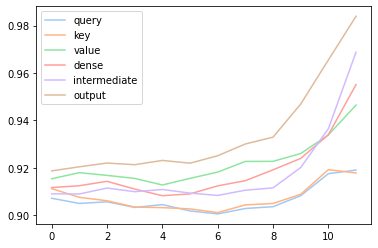

In [11]:
for name in sparsities:
    plt.plot(sparsities[name], label=name)
plt.legend()
plt.savefig("sparsity.pdf", format="pdf")
plt.show()

In [7]:
import seaborn as sns
data = []
name_mapping = {
    "query" : "Attn: Query",
    "key" : "Attn: Key",
    "value" : "Attn: Value",
    "dense" : "Attn: Output",
    "intermediate" : "Linear: Interm.",
    "output": "Linear: Output",
}
for name in sparsities:
    for layer in range(12):
        data.append([name_mapping[name], layer + 1, 1 - sparsities[name][layer]])
data = pd.DataFrame(data, columns=["Type", "Layer", "Pruning Rate"])
data

,Type,Layer,Pruning Rate
0,Attn: Query,1,0.092882
1,Attn: Query,2,0.095054
2,Attn: Query,3,0.094371
3,Attn: Query,4,0.096741
4,Attn: Query,5,0.095544
...,...,...,...
67,Linear: Output,8,0.069974
68,Linear: Output,9,0.067097
69,Linear: Output,10,0.053161
70,Linear: Output,11,0.034547


In [54]:
model.model.classifier

AttributeError: 'BertModel' object has no attribute 'classifier'

In [21]:
import matplotlib.style as style
style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [9]:
# style.use('seaborn-poster') #sets the size of the charts
# style.use('seaborn-muted')
sns.set_palette('pastel')

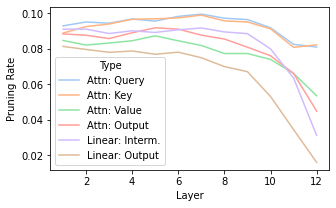

In [22]:
plt.figure(figsize=(5, 3))
sns.lineplot(data=data, x="Layer", y="Pruning Rate", hue="Type")
plt.savefig("pruning_rate.pdf", format="pdf", bbox_inches="tight")

In [ ]:
model.model.encoder.layer[0].attention.self.query.weight.shape

In [ ]:
# Queries

query_sparsities = []
for key in masks:
    
    if "query" in key:
        
        mask = masks[key]
        sparsities = []
        for i in range(0, mask.shape[0], 64):
            head = mask[i:i+64, :]
            sparsities.append(head.mean())
        query_sparsities.append(sparsities)

In [ ]:
for i in range(len(query_sparsities[0])):
    head_spars = [heads[i] for heads in query_sparsities]
    plt.plot(head_spars, label=str(i))
# plt.legend()
plt.show()

In [ ]:
# Value

value_sparsities = []
for key in masks:
    
    if "value" in key:
        
        mask = masks[key]
        sparsities = []
        for i in range(0, mask.shape[0], 64):
            head = mask[i:i+64, :]
            sparsities.append(head.mean())
        value_sparsities.append(sparsities)

In [ ]:
for i in range(len(value_sparsities[0])):
    head_spars = [heads[i] for heads in value_sparsities]
    plt.plot(head_spars, label=str(i))
# plt.legend()
plt.show()

In [ ]:
# Keys

key_sparsities = []
for key in masks:
    
    if "key" in key:
        
        mask = masks[key]
        sparsities = []
        for i in range(0, mask.shape[0], 64):
            head = mask[i:i+64, :]
            sparsities.append(head.mean())
        key_sparsities.append(sparsities)

In [ ]:
for i in range(len(key_sparsities[0])):
    head_spars = [heads[i] for heads in key_sparsities]
    plt.plot(head_spars, label=str(i))
# plt.legend()
plt.show()

In [ ]:
# Outputs

output_sparsities = []
for key in masks:
    
    if "value" in key:
        
        mask = masks[key]
        sparsities = []
        for i in range(0, mask.shape[0], 64):
            head = mask[:, i:i+64]
            sparsities.append(head.mean())
        output_sparsities.append(sparsities)

In [ ]:
for i in range(len(output_sparsities[0])):
    head_spars = [heads[i] for heads in output_sparsities]
    plt.plot(head_spars, label=str(i))
# plt.legend()
plt.show()